In [7]:
%pip install -U gym[atari,accept-rom-license]==0.19.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import gym

import tensorflow as tf
from tensorflow.keras import Sequential 
# from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt
import numpy as np
import cv2
from datetime import timedelta
import time
import random
from collections import deque

In [9]:
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [10]:
epochs = 100
MONITOR = True

In [11]:
class DQN():
    def __init__(self, env_string, batch_size=32, IM_SIZE=84, m=4):
            
        self.memory = deque(maxlen=100000)
        self.env = gym.make(env_string)
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.IM_SIZE = IM_SIZE
        self.m = m
        self.gamma = 0.99
        self.epsilon = 0.9
        self.epsilon_decay = 0.95
        self.epsilon_min = 0.15
        
        alpha = 0.00025
        alpha_decay = alpha / epochs
        self.training_history = []

        self.ROWS = 80
        self.COLS = 80
        self.REM_STEP = 4

        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        self.image_memory = np.zeros(self.state_size)
        
        # init model
        self.model = Sequential()
        self.model.add(Conv2D(32, 8, (4,4), activation='relu', padding='valid', input_shape=(IM_SIZE, IM_SIZE, m)))
        self.model.add(Conv2D(64, 4, (2,2), activation='relu', padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add(Conv2D(64, 3, (1,1), activation='relu', padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add(Flatten())
        self.model.add(Dense(512, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(learning_rate=alpha))
        self.model_target = tf.keras.models.clone_model(self.model)
        
        if MONITOR:
            self.env = gym.wrappers.Monitor(self.env, '../data/'+env_string, force=True)
            
    def combine_images(self, img1, img2):
        if len(img1.shape) == 3 and img1.shape[0] == self.m:
            im = np.append(img1[1:,:,:], np.expand_dims(img2, 0), axis=2)
            return tf.expand_dims(im, 0)
        else:
            im = np.stack([img1]*self.m, axis=2)
            return tf.expand_dims(im, 0)
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        x_batch, y_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state)
            a = np.argmax(self.model.predict(next_state)[0])
            y_target[0][action] = reward if done else reward + self.gamma * np.max(
                self.model_target.predict(next_state)[0][a])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        _hist = self.model.fit(
            np.array(x_batch), np.array(y_batch), batch_size=len(x_batch))
        self.training_history.append(_hist)
        
    def preprocess_state(self, img):
        img_temp = img[31:195] # choose important area of image
        img_temp = tf.image.rgb_to_grayscale(img_temp)
        img_temp = tf.image.resize(img_temp, [self.IM_SIZE, self.IM_SIZE],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        img_temp = tf.cast(img_temp, tf.float32)
        return img_temp[:,:,0]
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.env.action_space.n)
        else:
            action = np.argmax(self.model.predict(state))         
        return action
    
    def GetImage(self, frame):
        self.env.render()
        
        # croping frame to 80x80 size
        frame_cropped = frame[31:195:2, ::2,:]
        if frame_cropped.shape[0] != self.COLS or frame_cropped.shape[1] != self.ROWS:
            # OpenCV resize function 
            frame_cropped = cv2.resize(frame, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)
        
        # converting to RGB (numpy way)
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]
        # converting to RGB (OpenCV way)
        #frame_rgb = cv2.cvtColor(frame_cropped, cv2.COLOR_RGB2GRAY)     

        # dividing by 255 we expresses value to 0-1 representation
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0

        # push our data by 1 frame, similar as deq() function work
        self.image_memory = np.roll(self.image_memory, 1, axis = 0)

        # inserting new frame to free space
        self.image_memory[0,:,:] = new_frame

        # show image frame   
        #self.imshow(self.image_memory,0)
        #self.imshow(self.image_memory,1)
        #self.imshow(self.image_memory,2)
        #self.imshow(self.image_memory,3)
        
        return np.expand_dims(self.image_memory, axis=0)

    def reset(self):
        frame = self.env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage(frame)
        return state

    def train(self):
        start_time = time.process_time()
        scores = deque(maxlen=100)
        avg_scores = []
        frame_count = 0
        target_update_frequency = 500
        for e in range(epochs):       
            elapsed_seconds = time.process_time() - start_time
            elapsed_time = timedelta(seconds=elapsed_seconds)
            print('***** Epoch number: ' + str(e+1) + ' started.  Elapsed time so far: ' + str(elapsed_time) + ' *****')
            print('***** Epsilon: ' + str(self.epsilon) + ' *****')
            state = self.env.reset()
            state = self.preprocess_state(state)
            state = self.combine_images(state, state)
            done = False
            score = 0
            while not done:
                frame_count += 1
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                next_state = self.combine_images(next_state, state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if frame_count % 25 == 0:
                    self.replay(self.batch_size)
                    print('*** Training model ***')
                if frame_count % target_update_frequency == 0:
                    self.model_target.set_weights(self.model.get_weights())
                    print('*** Updated Target Model''s weights ***')
            scores.append(score)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score)
            if self.epsilon > self.epsilon_min and e >= 25 and e % 5 == 0:
                self.epsilon = self.epsilon * self.epsilon_decay
        self.model.save('model_1.h5')
        self.env.close()
        return avg_scores

    def test(self, model_name):
        self.model = load_model(model_name)
        for e in range(100):
            state = self.reset()
            done = False
            score = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e+1, 100, score))
                    break
        self.env.close()

In [12]:
env_string = 'BreakoutDeterministic-v4'
RL_agent = DQN(env_string)
scores = RL_agent.train()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 12ms/step - loss: 0.0073
*** Training model ***
1/1 [==============================] - 0s 12ms/step - loss: 0.0076
*** Training model ***
1/1 [==============================] - 0s 12ms/step - loss: 0.0066
*** Training model ***
1/1 [==============================] - 0s 12ms/step - loss: 0.0047
*** Training model ***
1/1 [==============================] - 0s 13ms/step - loss: 0.0630
*** Training model ***
1/1 [==============================] - 0s 13ms/step - loss: 0.0689
*** Training model ***
1/1 [==============================] - 0s 13ms/step - loss: 0.0068
*** Training model ***
1/1 [==============================] - 0s 24ms/step
***** Epoch number: 96 started.  Elapsed time so far: 1:40:44.368170 *****
***** Epsilon: 0.43890748120397666 *****
1/1 [==============================] - 0s 14ms/step - loss: 0.0050
*** Training model ***
*** Updated Target Models weights ***
1/1 [==================

In [13]:
print(scores)

[3.0, 1.5, 1.0, 1.25, 1.0, 1.0, 1.2857142857142858, 1.125, 1.1111111111111112, 1.1, 1.0909090909090908, 1.1666666666666667, 1.1538461538461537, 1.0714285714285714, 1.0666666666666667, 1.3125, 1.2941176470588236, 1.2777777777777777, 1.263157894736842, 1.45, 1.4285714285714286, 1.4545454545454546, 1.391304347826087, 1.375, 1.4, 1.3461538461538463, 1.3333333333333333, 1.3928571428571428, 1.4827586206896552, 1.4333333333333333, 1.3870967741935485, 1.40625, 1.4242424242424243, 1.3823529411764706, 1.4, 1.4444444444444444, 1.4864864864864864, 1.4736842105263157, 1.4871794871794872, 1.475, 1.4390243902439024, 1.5, 1.4651162790697674, 1.4772727272727273, 1.4444444444444444, 1.4130434782608696, 1.3829787234042554, 1.375, 1.3673469387755102, 1.36, 1.3529411764705883, 1.3461538461538463, 1.3396226415094339, 1.3333333333333333, 1.3272727272727274, 1.375, 1.368421052631579, 1.3793103448275863, 1.3559322033898304, 1.4, 1.4098360655737705, 1.403225806451613, 1.3968253968253967, 1.40625, 1.415384615384

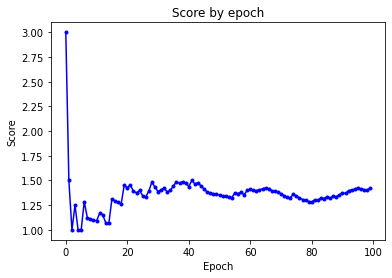

In [14]:
plt.plot(scores, color='blue', marker='.') #plot the data

plt.title('Score by epoch')
plt.ylabel('Score') #set the label for y axis
plt.xlabel('Epoch') #set the label for x-axis
plt.show() #display the graph

In [15]:
_loss_history = [x.history['loss'] for x in RL_agent.training_history]

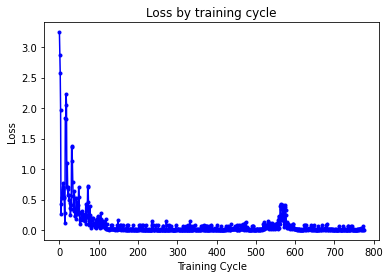

In [16]:
plt.plot(_loss_history, color='blue', marker='.') #plot the data

plt.title('Loss by training cycle')
plt.ylabel('Loss') #set the label for y axis
plt.xlabel('Training Cycle') #set the label for x-axis
plt.show() #display the graph

In [17]:
# RL_agent.test('model_1.h5')